In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import networkx as nx
from networkx.algorithms import bipartite
%matplotlib inline

# Question 1

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [83]:
data = pd.read_csv('lalonde.csv', index_col=0)

data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [84]:
treated_group = data[data['treat'] == 1]
untreated_group = data[data['treat'] == 0]

In [115]:
treated_desc = treated_group['re78'].describe().rename("Treated")
treated_desc.set_value('median', treated_group['re78'].median())

untreated_desc = untreated_group['re78'].describe().rename("Untreated")
untreated_desc.set_value('median', untreated_group['re78'].median())

stats_df = pd.concat([treated_desc, untreated_desc], axis=1)
stats_df

,Treated,Untreated
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000
median,4232.309000,4975.505000




Now lets display some plots of the distribution to visually see what it looks like.

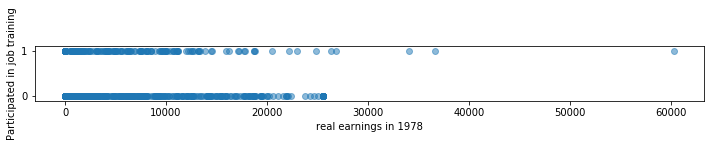

In [86]:
plt.figure(figsize=(12,1))
plt.scatter(data['re78'], data['treat'], alpha=0.5)
plt.xlabel('real earnings in 1978')
plt.ylabel('Participated in job training')

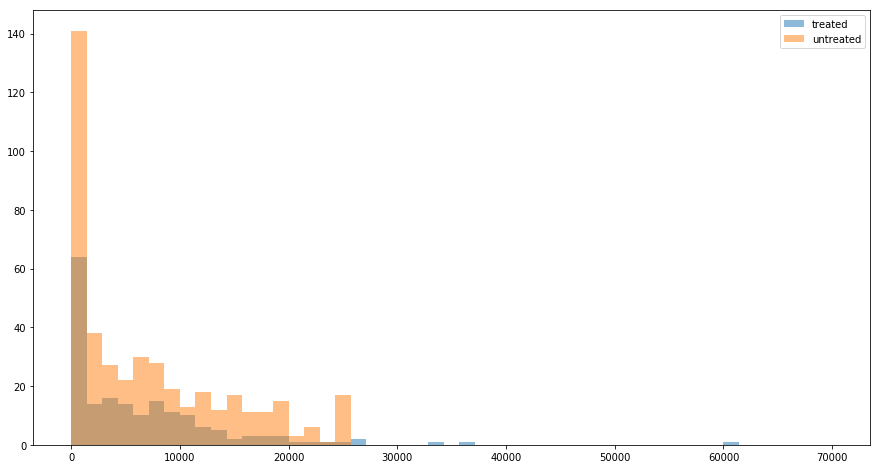

In [87]:
bins = np.linspace(0,70000, 50)

plt.figure(figsize=(15,8))
plt.hist(treated_group['re78'], bins, alpha=0.5, label='treated')
plt.hist(untreated_group['re78'], bins, alpha=0.5, label='untreated')
plt.legend(loc='upper right')
plt.show()

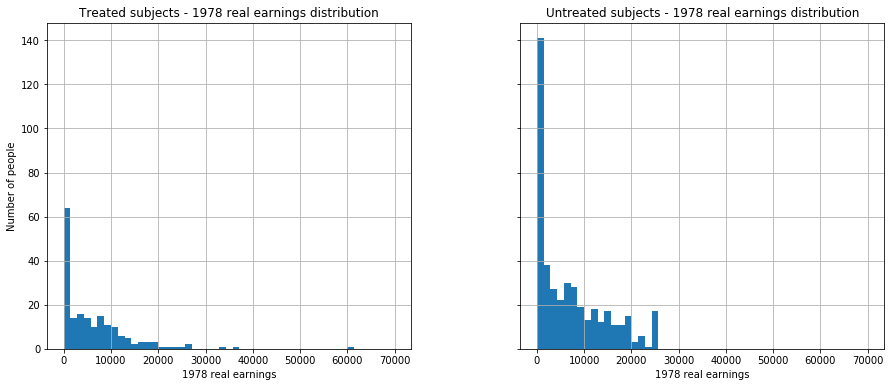

In [88]:
def draw_hists(data1, data2, title, xlabel, ylabel, column):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6), sharex=True, sharey=True)
    data1.hist(column, bins=bins, label='treated', ax=ax1)
    data2.hist(column, bins=bins, label='untreated', ax=ax2)
    set_axis(ax1, True, title, xlabel)
    set_axis(ax2, False, title, xlabel)
    ax1.set_ylabel(ylabel)

def set_axis(ax, treated, title, xlabel=None):
    if treated:
        ax.set_title('Treated '+ title)
    else:
        ax.set_title('Untreated ' + title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    return


draw_hists(treated_group, untreated_group, 'subjects - 1978 real earnings distribution', 
          '1978 real earnings', 'Number of people', 're78')

Some observations:
- The max earning value for the treated group is way higher than the max earning for the untreated group, but the mean and median values are higher for the untreated group, which leads us to think that the treated group overall didn't get better results, even though some outliers did get a very good outcome from the trainee program. We can also observe the higher standard deviation for the treated group, which goes in the same direction.
- The absolute number of subjects with zero earnings (no job) in 1978 is way higher in the control group, which leads to think the program was successful in bringing a job to the participants.
- Some subjects from the treated group came out quite successfully from the training program, earning much more than the meadian earning. These outliers can be considered as special cases of people that, with the help of the program, were able to motivate themselves a lot and get a good paying job.

In this first observation, we could conclude that **the training program was unsuccessful** for most of the participants.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [89]:
treated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [90]:
untreated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


It's always easier to look at pictures than numbers, so let us start with continious data of age and years of education. We will build the box plots to observe that the treated group is generally younger and that the distribution of years of education is similar, except that the untreated group has a couple of outliers more.

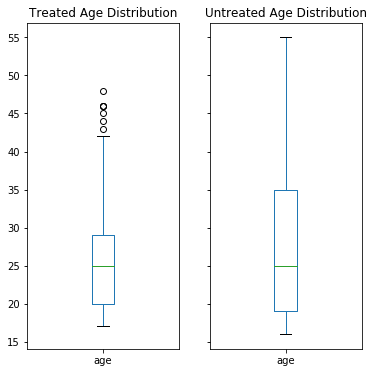

In [91]:
def drawBoxPlot (data1, data2, title, col):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,6), sharex=True, sharey=True)
    treated_group[col].plot.box(ax=ax1)
    untreated_group[col].plot.box(ax=ax2)
    set_axis(ax1, True, title)
    set_axis(ax2, False, title)

drawBoxPlot(treated_group, untreated_group, 'Age Distribution', 'age')

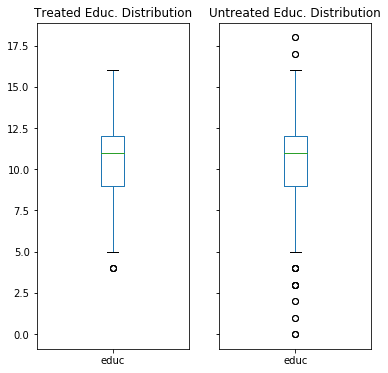

In [92]:
drawBoxPlot(treated_group, untreated_group, 'Educ. Distribution', 'educ')

Now let's have a look at the distribution of real earnings before the treatment.

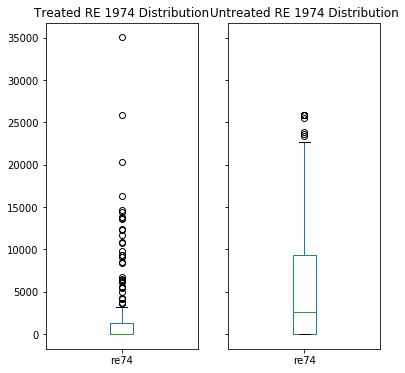

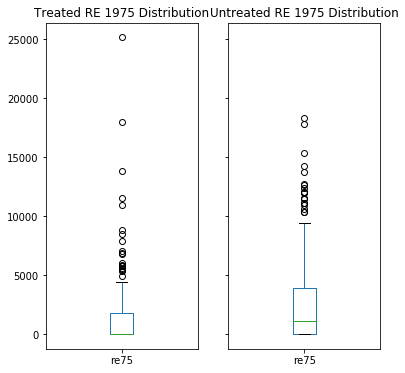

In [93]:
drawBoxPlot(treated_group, untreated_group, 'RE 1974 Distribution', 're74')
drawBoxPlot(treated_group, untreated_group, 'RE 1975 Distribution', 're75')

Here is something interesting: before the trearment the treated group was earning significantly less then untreated group. Moreover there are a couple of outliers in the treated group that earned a lot more then the mean of the group, that might explain the outliers in the real earnings distribution after the treatment.

Below, we compare the percent of true/false values for features concerning race ('black' and 'hispan'), marriage and degree for each group and compare in bar charts.

We also plot the distributions for the age, education and income prior to the experience to compare between the two groups.

These observations will let us determine if the two groups are equivalently distributed.

black percent for treated group: 84.32%
black percent for untreated group: 20.28%



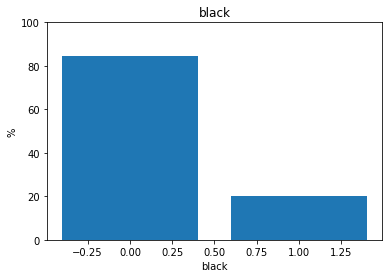

hispan percent for treated group: 5.95%
hispan percent for untreated group: 14.22%



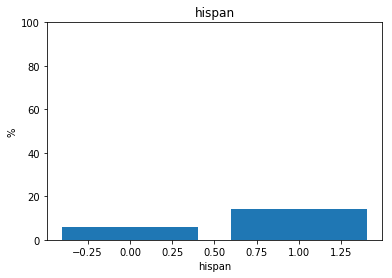

married percent for treated group: 18.92%
married percent for untreated group: 51.28%



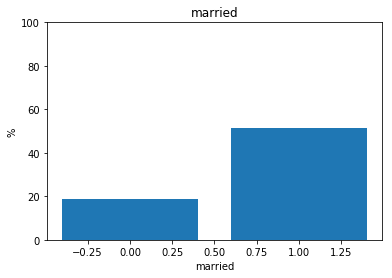

nodegree percent for treated group: 70.81%
nodegree percent for untreated group: 59.67%



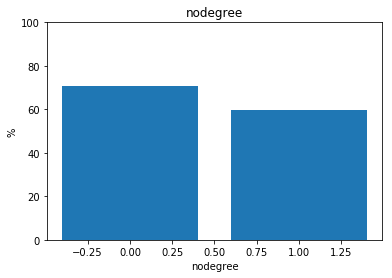

[None, None, None, None]

In [94]:
def percentage_comparison(treated_g, untreated_g, feature):
    treated_percent = 100 * np.sum(treated_g[feature]) / treated_g[feature].size
    untreated_percent = 100 * np.sum(untreated_g[feature]) / untreated_g[feature].size
    print('{} percent for treated group: {:0.2f}%'.format(feature, treated_percent))
    print('{} percent for untreated group: {:0.2f}%'.format(feature, untreated_percent))
    print()
    
    x = [u'True', u'False']
    y = [treated_percent, untreated_percent]
    fig, ax = plt.subplots() 
    plt.bar([0,1], [treated_percent, untreated_percent])
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('%')
    
    ax.set_ylim([0,100])
    
    plt.show()

features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(treated_group, untreated_group, f) for f in features_to_compare]

# TODO plot values above in small bar charts with yaxis 100% to compare visually
# TODO plot in subplots side by side, nicer
# Display bar value in each bar
# TODO plot age distribution, plot years of education, display income before exp
# TODO box plots?
# TODO new column with 'race_other' (if black and hispan == 0)

- Proportionally, the number of blacks in the control group is way higher than in the treated group.
- There is also a disreptancy in the percentage of married people in each group


These observations show that the treatment assignment isn't random and there is a huge bias between the two groups in some of the covariates, such as the number of blacks. This doesn't correspond to a randomized experiment. Such disruptancies cause major differences in the groups, which alone is enough to invalidate the naive conclusions made in part 1, or at least put the above findings into question.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [95]:
logistic = LogisticRegression()

confounders = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
#confounders = ['age', 'educ', 'hispan', 'married', 'nodegree', 're74', 're75']

y = data['treat']
X = data[confounders]
logistic.fit(X, y)

prop_score = [e for (_,e) in logistic.predict_proba(X)]

data['prop_score'] = prop_score
data.head()

# TODO way to ignore re74 and re75 when zero? That would be possible only if we get rid of those lines all together
# But then there is a problem See the comment below

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


Which means, for example, that the second person in the above array has a 14.5% chance of being in the treated group.


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [96]:
treat_prop = data[data['treat'] == 1]['prop_score']
untreat_prop = data[data['treat'] == 0]['prop_score']

#B = nx.complete_bipartite_graph(treat_prop.size, untreat_prop.size)

B = nx.Graph()

B.add_nodes_from(treat_prop.index, bipartite=0)
B.add_nodes_from(untreat_prop.index, bipartite=1)

for l_idx, l in treat_prop.iteritems():
    for r_idx, r in untreat_prop.iteritems():
        w = 1 - abs(l - r)
        B.add_edge(l_idx, r_idx, weight=w)

max_matching = nx.max_weight_matching(B, True)
#max_matching

# TODO is this matching correct? Histogram seems fishy, too many high values??
# I think it;s bacause of the zero values in re74 and re75 But we can;t just get rid of them, as they entail
# some meaning. The zero's may mean that there was no real imcome for that person that year. But then how likely is it?

To check how good our matching performed, we compute the absolute difference between the two propensity scores for each pair in the matching and display a histogram of all the values.

Mean absolute propensity score: 0.19142320028243634


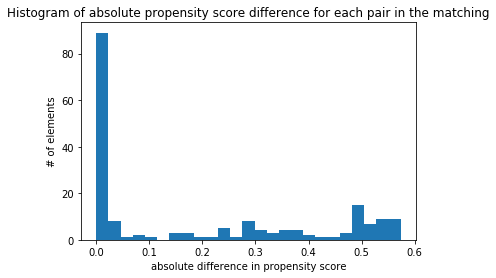

In [97]:
def get_scores(matching):
    (left, _) = bipartite.sets(B)
    return [abs(treat_prop[l] - untreat_prop[matching[l]]) for l in left]

abs_diffs = get_scores(max_matching)
print('Mean absolute propensity score: {}'.format(np.mean(abs_diffs)))

plt.hist(abs_diffs,bins=25)
plt.title('Histogram of absolute propensity score difference for each pair in the matching')
plt.xlabel('absolute difference in propensity score')
plt.ylabel('# of elements')
plt.show()

As we can see, the algorithm found many good matchings, but there is a lot of pairs that have a big difference in propensity score, due to the fact that strictly each score has to be matched with one from the other group.

In [98]:
#left side is the treated nodes, right side is untreated nodes (size)
(left, right) = bipartite.sets(B)

print('Left (treated): {}'.format(len(left)))
print('Right (untreated): {}'.format(len(right)))

Left (treated): 185
Right (untreated): 429


The left side of the bipartite graph is the smallest, thus the matching contains all nodes on the left side (185) and has matched with 185 nodes on the right side (untreated patients).

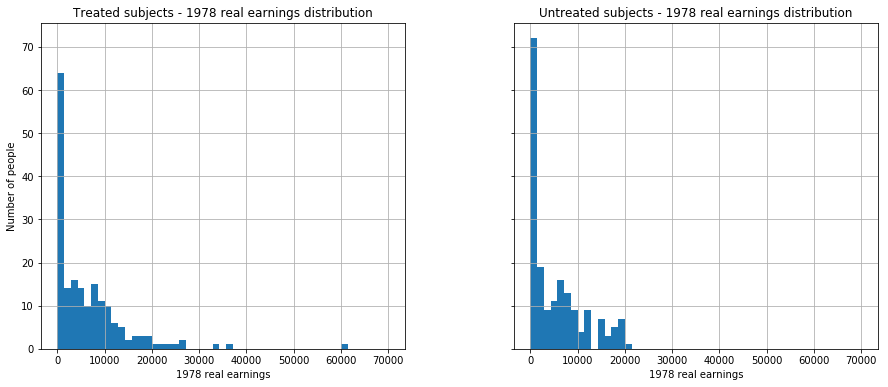

In [99]:
treated_matched_index = left #are all matched
untreated_matched_index = [max_matching[l] for l in left]
len(untreated_matched_index)

# Get only the matched proensity scores for each group
matched_treated_group = data.loc[treated_matched_index]
matched_untreated_group = data.loc[untreated_matched_index]

draw_hists(matched_treated_group, matched_untreated_group, 'subjects - 1978 real earnings distribution', 
          '1978 real earnings', 'Number of people', 're78')

Now, with the propensity score matching, we have an observational study and looking at the results of 1978 earnings, we could conclude that the treatment did work well for the outliers that earned a lot more than the rest. There is also less people with no income in the treated group.

black percent for treated group: 84.32%
black percent for untreated group: 47.03%



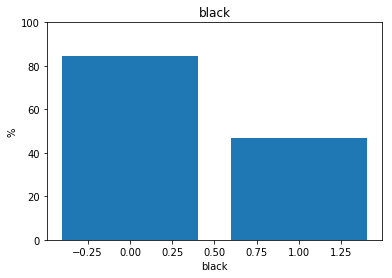

hispan percent for treated group: 5.95%
hispan percent for untreated group: 11.89%



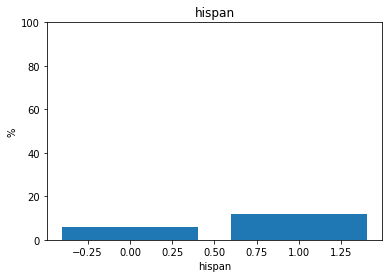

married percent for treated group: 18.92%
married percent for untreated group: 16.76%



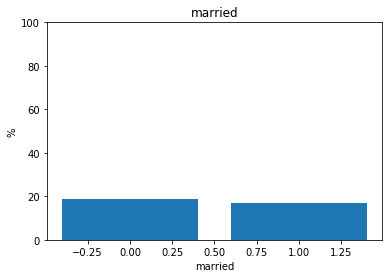

nodegree percent for treated group: 70.81%
nodegree percent for untreated group: 62.70%



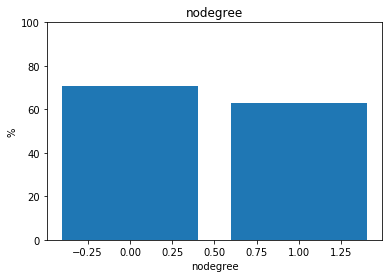

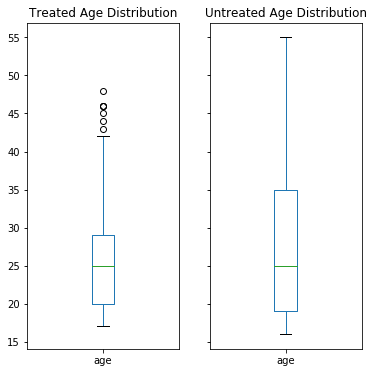

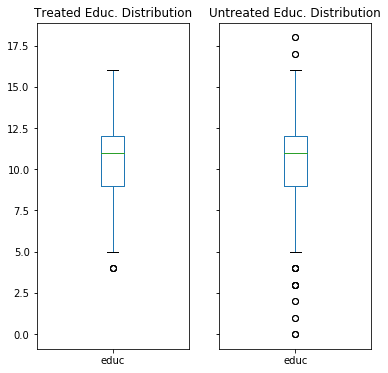

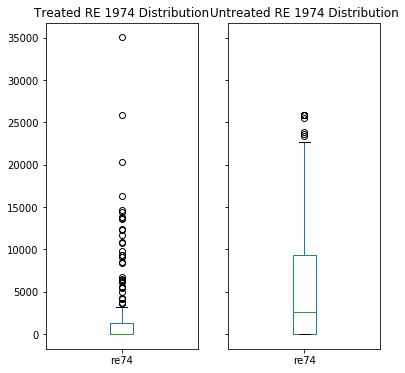

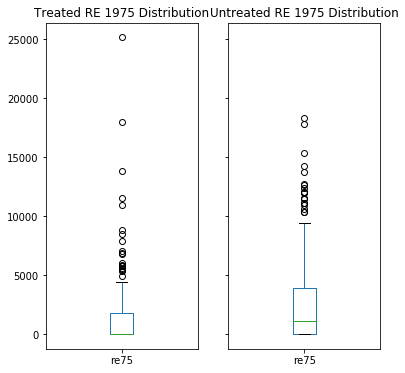

In [100]:
features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(matched_treated_group, matched_untreated_group, f) for f in features_to_compare]

drawBoxPlot(matched_treated_group, matched_untreated_group, 'Age Distribution', 'age')
drawBoxPlot(matched_treated_group, matched_untreated_group, 'Educ. Distribution', 'educ')
drawBoxPlot(matched_treated_group, matched_untreated_group, 'RE 1974 Distribution', 're74')
drawBoxPlot(matched_treated_group, matched_untreated_group, 'RE 1975 Distribution', 're75')



Even though the number of blacks, for example, is still relatively different in each group, the differences are smaller for each feature and the groups look better distributed.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


Our matching in part 4 makes feature-values distributions somewhat better, but there is still considerable imbalance in such features as 'black', 'married' and a little bit in 'hispan'. Therefore we can't say our dataset is balanced.
A possible way to improve the imbalance of our dataset is to prohibit cross-ratial matches. Therefore our next step is to correct the balance of our dataset by matching two datapoints only if thery are both black or non-black.

In [101]:
treat_prop = data[data['treat'] == 1]['prop_score']
untreat_prop = data[data['treat'] == 0]['prop_score']
# We create a graph
BB = nx.Graph()

BB.add_nodes_from(treat_prop.index, bipartite=0)
BB.add_nodes_from(untreat_prop.index, bipartite=1)

for l_idx, l in treat_prop.iteritems():
    for r_idx, r in untreat_prop.iteritems():
        leftBlack = np.asscalar(data[data.index == l_idx]['black']);
        rightBlack = np.asscalar(data[data.index == r_idx]['black']);
        # Check and match only if the value of the 'black feature is the same
        if (leftBlack == rightBlack): 
            # Since we are going to maximise the graph, ans we need the smallest differences, the weight assigned is 
            # - absolute differece
            w = -(abs(l - r))
            BB.add_edge(l_idx, r_idx, weight=w)

max_matching = nx.max_weight_matching(BB, True)
max_matching

{'NSW1': 'PSID27',
 'NSW10': 'PSID40',
 'NSW100': 'PSID274',
 'NSW104': 'PSID374',
 'NSW105': 'PSID388',
 'NSW107': 'PSID158',
 'NSW110': 'PSID368',
 'NSW111': 'PSID420',
 'NSW112': 'PSID205',
 'NSW113': 'PSID352',
 'NSW115': 'PSID46',
 'NSW116': 'PSID227',
 'NSW119': 'PSID196',
 'NSW12': 'PSID381',
 'NSW120': 'PSID15',
 'NSW122': 'PSID110',
 'NSW123': 'PSID333',
 'NSW124': 'PSID194',
 'NSW125': 'PSID103',
 'NSW127': 'PSID159',
 'NSW129': 'PSID313',
 'NSW13': 'PSID269',
 'NSW130': 'PSID326',
 'NSW131': 'PSID406',
 'NSW132': 'PSID423',
 'NSW133': 'PSID99',
 'NSW134': 'PSID238',
 'NSW135': 'PSID41',
 'NSW137': 'PSID166',
 'NSW139': 'PSID98',
 'NSW14': 'PSID217',
 'NSW140': 'PSID409',
 'NSW145': 'PSID156',
 'NSW147': 'PSID291',
 'NSW150': 'PSID330',
 'NSW151': 'PSID337',
 'NSW152': 'PSID293',
 'NSW153': 'PSID268',
 'NSW155': 'PSID354',
 'NSW157': 'PSID157',
 'NSW16': 'PSID412',
 'NSW161': 'PSID335',
 'NSW163': 'PSID96',
 'NSW164': 'PSID419',
 'NSW165': 'PSID134',
 'NSW166': 'PSID102',
 'N

Now that the new matching is done, let's check how good it is.
First we will build the histogram of the whole matchet dataset. We can already see that it's better then the naive approach. Separate histograms per group build for even stronger case.

116
Mean absolute propensity score: 0.007397054659236818


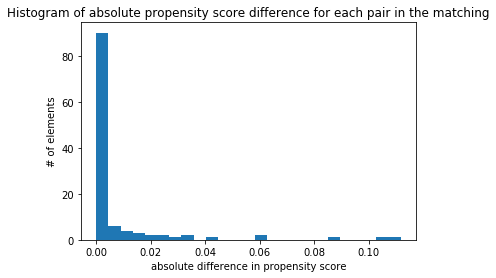

In [102]:
def get_scores_black(matching):
    (left, right) = bipartite.sets(BB)
    result = []
    counter = 0
    for l in left:
        if l in matching.keys():
            result.append(abs(treat_prop[l] - untreat_prop[matching[l]]))
            counter = counter + 1
    print(counter)
    return result

abs_diffs_black = get_scores_black(max_matching)
print('Mean absolute propensity score: {}'.format(np.mean(abs_diffs_black)))
plt.hist(abs_diffs_black,bins=25)
plt.title('Histogram of absolute propensity score difference for each pair in the matching')
plt.xlabel('absolute difference in propensity score')
plt.ylabel('# of elements')
plt.show()

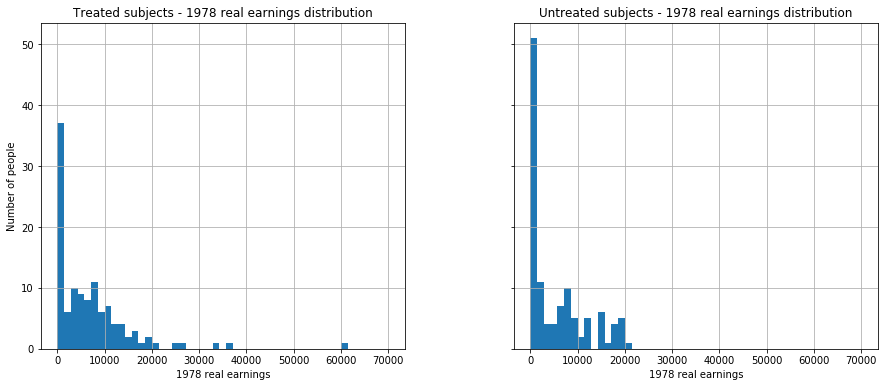

In [103]:
# Need to separate data manually as not everything got matched on the left of the bipartite graph
(left, right) = bipartite.sets(BB)
treated_matched_index = []
untreated_matched_index = []
for l in left:
        if l in max_matching.keys():
            treated_matched_index.append(l)
            untreated_matched_index.append(max_matching[l])
len(treated_matched_index)
len(untreated_matched_index)

# Get only the matched datapionts for each group
matched_treated_group = data.loc[treated_matched_index]
matched_untreated_group = data.loc[untreated_matched_index]

matched_treated_group_by_black = matched_treated_group
matched_untreated_group_by_black = matched_untreated_group

draw_hists(matched_treated_group, matched_untreated_group, 'subjects - 1978 real earnings distribution', 
          '1978 real earnings', 'Number of people', 're78')

Now that we have a rough idea about the quality of our new matching, let's check how matching on 'black' affected other feature values.
Obviously we have same amount of 'black' in both groups, 'married' got very close to being the same, 'hispan' imbalance got turned around, and there seems to be no effect on the 'nodegree'.
This could possibly lead us to believe that the 'black' and 'mariied' features depend on each other in some way. Later we will try to match on 'married' and see if it affects 'black'.

black percent for treated group: 75.00%
black percent for untreated group: 75.00%



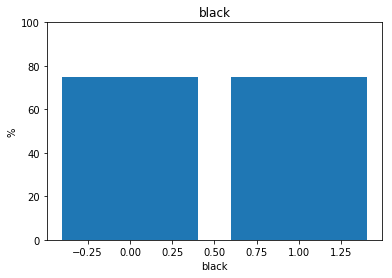

hispan percent for treated group: 9.48%
hispan percent for untreated group: 5.17%



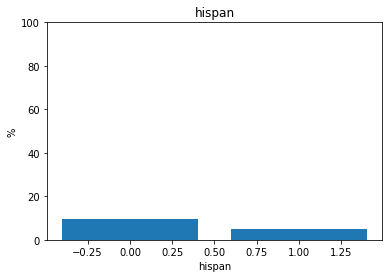

married percent for treated group: 24.14%
married percent for untreated group: 25.86%



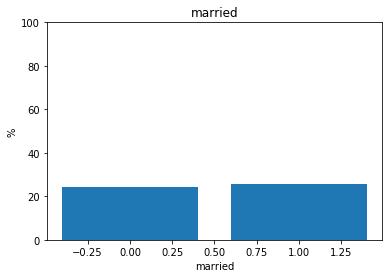

nodegree percent for treated group: 68.97%
nodegree percent for untreated group: 62.93%



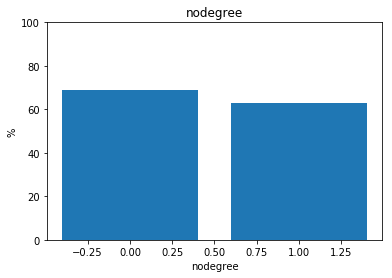

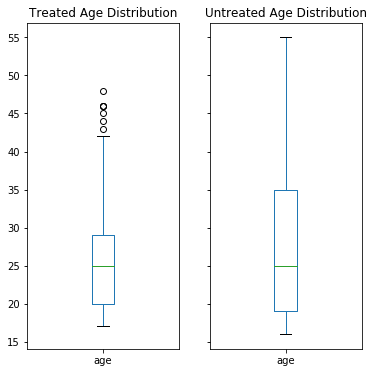

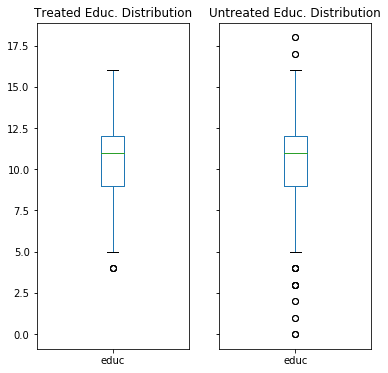

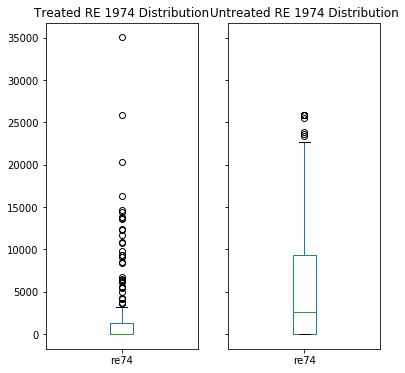

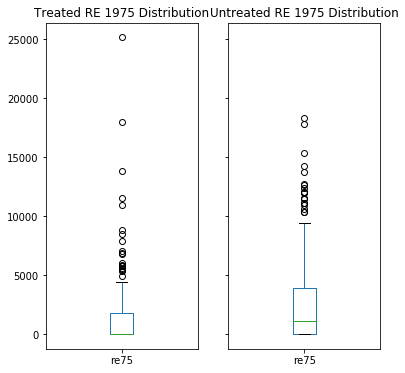

In [104]:
features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(matched_treated_group, matched_untreated_group, f) for f in features_to_compare]

drawBoxPlot(matched_treated_group, matched_untreated_group, 'Age Distribution', 'age')
drawBoxPlot(matched_treated_group, matched_untreated_group, 'Educ. Distribution', 'educ')
drawBoxPlot(matched_treated_group, matched_untreated_group, 'RE 1974 Distribution', 're74')
drawBoxPlot(matched_treated_group, matched_untreated_group, 'RE 1975 Distribution', 're75')

Now as promissed let's look at matching based on 'married'. Will it affect the 'black' in the same way 'black' affected 'married'?

In [105]:
treat_prop = data[data['treat'] == 1]['prop_score']
untreat_prop = data[data['treat'] == 0]['prop_score']

#B = nx.complete_bipartite_graph(treat_prop.size, untreat_prop.size)

BM = nx.Graph()

BM.add_nodes_from(treat_prop.index, bipartite=0)
BM.add_nodes_from(untreat_prop.index, bipartite=1)

for l_idx, l in treat_prop.iteritems():
    for r_idx, r in untreat_prop.iteritems():
        leftMarried = np.asscalar(data[data.index == l_idx]['married']);
        rightMarried = np.asscalar(data[data.index == r_idx]['married']);
        if (leftMarried == rightMarried): 
            w = -(abs(l - r))
            BM.add_edge(l_idx, r_idx, weight=w)

max_matching = nx.max_weight_matching(BM, True)
max_matching

{'NSW1': 'PSID249',
 'NSW10': 'PSID40',
 'NSW100': 'PSID274',
 'NSW101': 'PSID245',
 'NSW102': 'PSID377',
 'NSW103': 'PSID247',
 'NSW104': 'PSID374',
 'NSW105': 'PSID388',
 'NSW106': 'PSID89',
 'NSW107': 'PSID237',
 'NSW108': 'PSID234',
 'NSW109': 'PSID251',
 'NSW11': 'PSID145',
 'NSW110': 'PSID368',
 'NSW111': 'PSID414',
 'NSW112': 'PSID205',
 'NSW113': 'PSID352',
 'NSW114': 'PSID346',
 'NSW115': 'PSID46',
 'NSW116': 'PSID227',
 'NSW117': 'PSID253',
 'NSW118': 'PSID278',
 'NSW119': 'PSID369',
 'NSW12': 'PSID381',
 'NSW120': 'PSID281',
 'NSW121': 'PSID424',
 'NSW122': 'PSID399',
 'NSW123': 'PSID258',
 'NSW124': 'PSID194',
 'NSW125': 'PSID103',
 'NSW126': 'PSID380',
 'NSW127': 'PSID209',
 'NSW128': 'PSID27',
 'NSW129': 'PSID313',
 'NSW13': 'PSID269',
 'NSW130': 'PSID326',
 'NSW131': 'PSID406',
 'NSW132': 'PSID184',
 'NSW133': 'PSID16',
 'NSW134': 'PSID261',
 'NSW135': 'PSID41',
 'NSW136': 'PSID355',
 'NSW137': 'PSID166',
 'NSW138': 'PSID423',
 'NSW139': 'PSID99',
 'NSW14': 'PSID152',
 '

185
Mean absolute propensity score: 0.19543065324785472


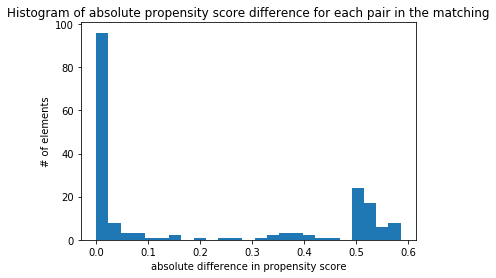

In [106]:
def get_scores_married(matching):
    (left, right) = bipartite.sets(BM)
    #print(left)
    #print(right)
    result = []
    counter = 0
    for l in left:
        if l in matching.keys():
            result.append(abs(treat_prop[l] - untreat_prop[matching[l]]))
            counter = counter + 1
    print(counter)
    return result

abs_diffs_black = get_scores_married(max_matching)
print('Mean absolute propensity score: {}'.format(np.mean(abs_diffs_black)))
plt.hist(abs_diffs_black,bins=25)
plt.title('Histogram of absolute propensity score difference for each pair in the matching')
plt.xlabel('absolute difference in propensity score')
plt.ylabel('# of elements')
plt.show()

We can already observe a bump at the end of the histogram showing existance of some data point matchings for which the difference in propensity score is larger, which could mean poorer matching then on 'black'.

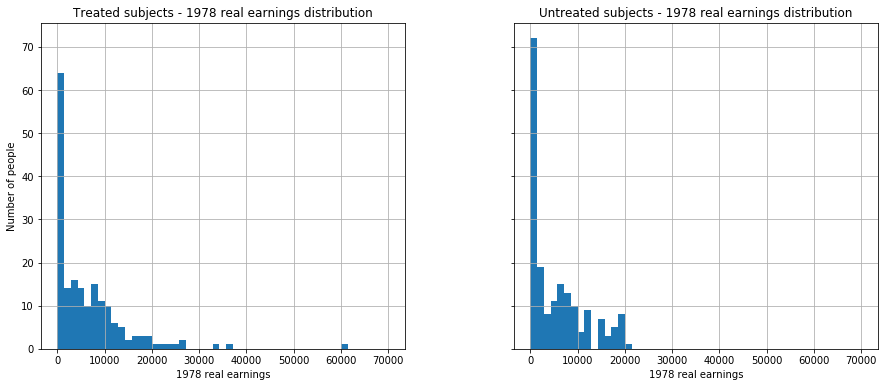

In [107]:
# Need to separate data manually again as not everything got matched on the left of the bipartite graph
(left, right) = bipartite.sets(BB)
treated_matched_index = []
untreated_matched_index = []
for l in left:
        if l in max_matching.keys():
            treated_matched_index.append(l)
            untreated_matched_index.append(max_matching[l])
len(treated_matched_index)
len(untreated_matched_index)

# Get only the matched datapionts for each group
matched_treated_group_by_married = data.loc[treated_matched_index]
matched_untreated_group_by_married = data.loc[untreated_matched_index]

draw_hists(matched_treated_group_by_married, matched_untreated_group_by_married, 'subjects - 1978 real earnings distribution', 
          '1978 real earnings', 'Number of people', 're78')

black percent for treated group: 84.32%
black percent for untreated group: 47.03%



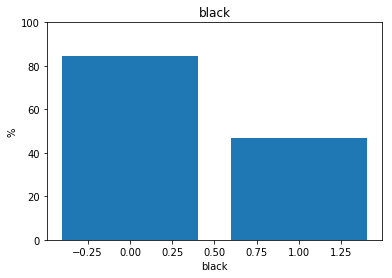

hispan percent for treated group: 5.95%
hispan percent for untreated group: 12.43%



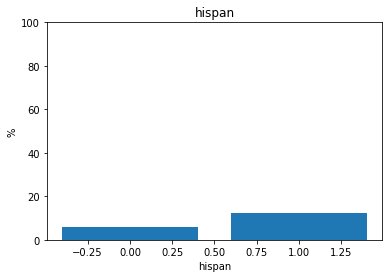

married percent for treated group: 18.92%
married percent for untreated group: 18.92%



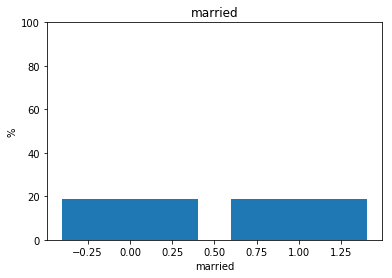

nodegree percent for treated group: 70.81%
nodegree percent for untreated group: 63.78%



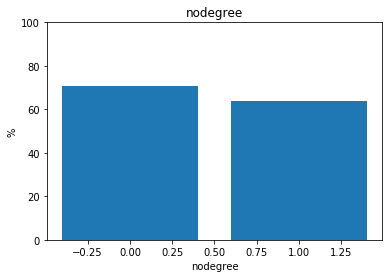

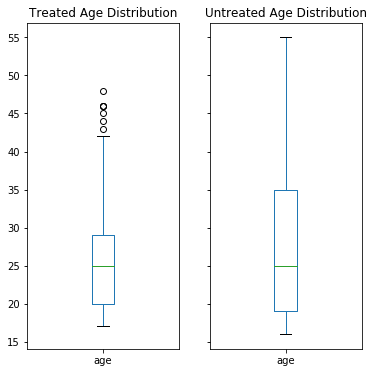

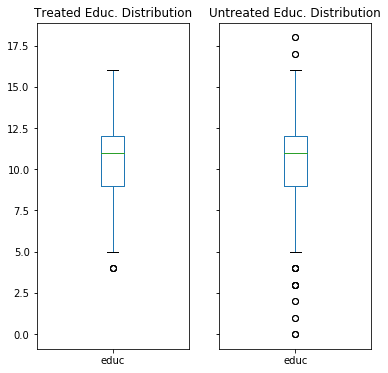

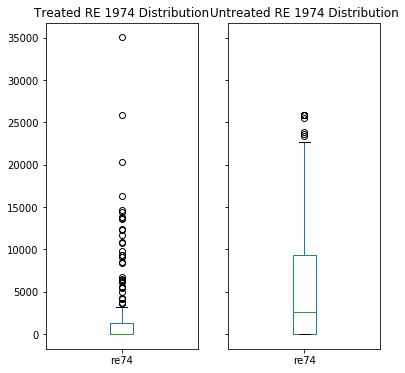

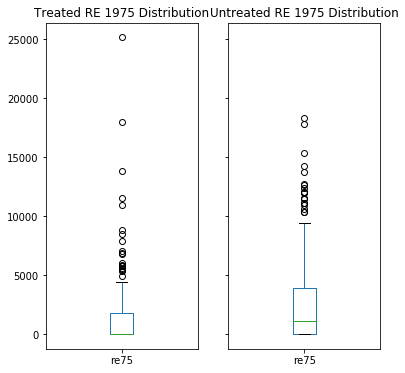

In [108]:
features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(matched_treated_group_by_married, matched_untreated_group_by_married, f) for f in features_to_compare]

drawBoxPlot(matched_treated_group_by_married, matched_untreated_group_by_married, 'Age Distribution', 'age')
drawBoxPlot(matched_treated_group_by_married, matched_untreated_group_by_married, 'Educ. Distribution', 'educ')
drawBoxPlot(matched_treated_group_by_married, matched_untreated_group_by_married, 'RE 1974 Distribution', 're74')
drawBoxPlot(matched_treated_group_by_married, matched_untreated_group_by_married, 'RE 1975 Distribution', 're75')

As you may see, matching on 'married' does not guarantee a match on 'black', which could possibly indicate only one way dependance. Since the matching on 'married' is more imbalanced, we will continue with dataset matched on 'black' even if that reduces it significantly.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [114]:
matched_treated_desc = matched_treated_group_by_black['re78'].describe().rename("Treated")
matched_treated_desc.set_value('median', matched_treated_group_by_black['re78'].median())

matched_untreated_desc = matched_untreated_group_by_black['re78'].describe().rename("Untreated")
matched_untreated_desc.set_value('median', matched_untreated_group_by_black['re78'].median())

stats_df = pd.concat([matched_treated_desc, matched_untreated_desc], axis=1)
stats_df

,Treated,Untreated
count,116.000000,116.000000
mean,7070.710510,5255.063148
std,8607.704795,6166.935322
min,0.000000,0.000000
25%,672.490925,0.000000
50%,5130.757500,2283.087500
75%,10011.045500,8340.658000
max,60307.930000,20243.380000
median,5130.757500,2283.087500


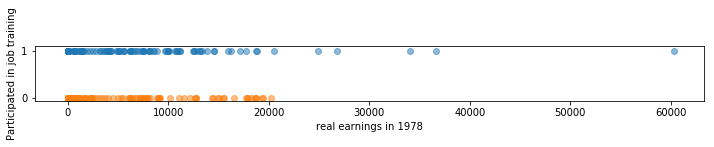

In [110]:
plt.figure(figsize=(12,1))
plt.scatter(matched_treated_group_by_black['re78'], matched_treated_group_by_black['treat'], alpha=0.5)
plt.scatter(matched_untreated_group_by_black['re78'], matched_untreated_group_by_black['treat'], alpha=0.5)
plt.xlabel('real earnings in 1978')
plt.ylabel('Participated in job training')

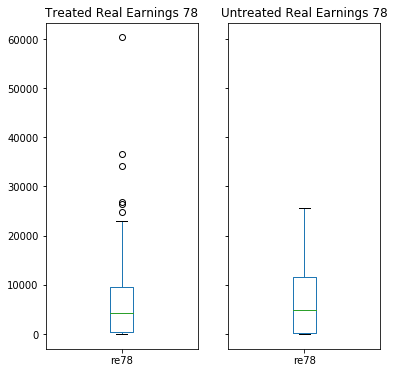

In [111]:
drawBoxPlot(matched_treated_group_by_black, matched_untreated_group_by_black, 'Real Earnings 78', 're78')

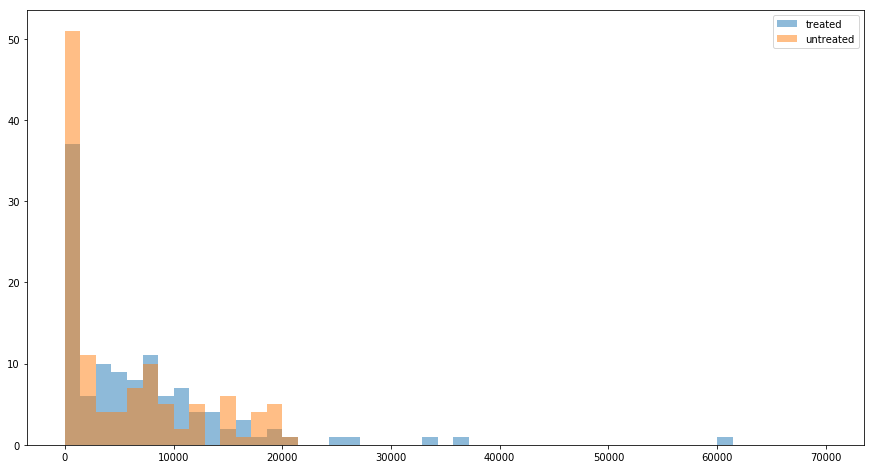

In [112]:
bins = np.linspace(0,70000, 50)

plt.figure(figsize=(15,8))
plt.hist(matched_treated_group_by_black['re78'], bins, alpha=0.5, label='treated')
plt.hist(matched_untreated_group_by_black['re78'], bins, alpha=0.5, label='untreated')
plt.legend(loc='upper right')
plt.show()

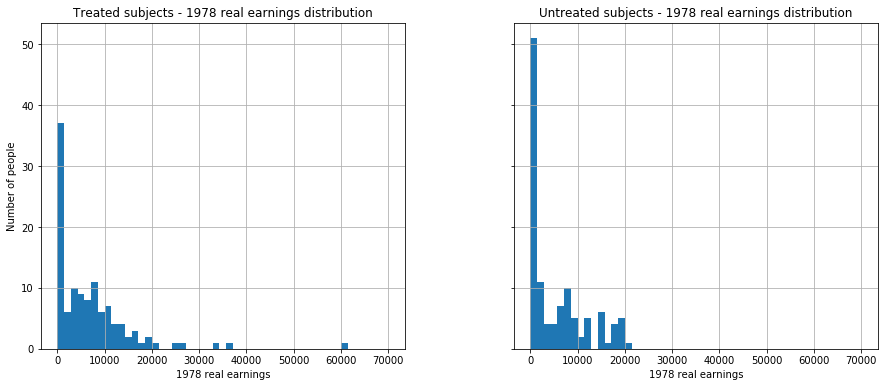

In [113]:
draw_hists(matched_treated_group_by_black, matched_untreated_group_by_black, 'subjects - 1978 real earnings distribution', 
          '1978 real earnings', 'Number of people', 're78')

Now that the groups are realtively balanced, we may observe that the datapoints of the untreated group appear squished to the left unlike the datapoints for the treated group, which have their outliers further up the re78 axis. That and looking a the quirtile ranges, we may conclude that the treatment is effective.

#TODO
- concl: without taking outliers into consideration, treated has slightly worse results, but taking into account all 232 subjects from the two groups, the median, mean are higher for the treated group
- concl: in treated subjects, less have zero income (no job) in 1978
- compare relative earning before after experiment
- precise that our conclusions are written when considering the objective of getting a higher earning after experiment; only takes into account the earnings and not the standard of living/happiness of the subject.

## Question 2: Applied ML
We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!


#### 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [117]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import sys
import itertools

We fetch the newsgroup data and display the 20 categories, then compute the tf-idf scores:

In [121]:
newsgroups_all = fetch_20newsgroups(subset='all')

list(newsgroups_all.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
# Compute the tf-idf score for each data point
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_all.data)
tfidf_score = vectors.data

In this problem the label of a data point is the news category assigned to it ('target' attribute in the newsgroup dataset) and the features are tf-idf values of the text of the news article. We split the dataset into train, test and validation sets.

In [6]:
# We first split into 0.8 train, then split the remaining (0.2) into half test half validation set
X = vectors
y = newsgroups_all.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=69)

print('X Train / Test / Validation size : {} / {} / {}'.format(X_train.shape, X_test.shape, X_val.shape))
print('y Train / Test / Validation size : {} / {} / {}'.format(y_train.shape, y_test.shape, y_val.shape))


X Train / Test / Validation size : (15076, 173762) / (1885, 173762) / (1885, 173762)
y Train / Test / Validation size : (15076,) / (1885,) / (1885,)


#### 2. 
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



In [38]:
# Train a random forest with the given parameters and return the accuracy of the model
def test_rf(x_train, y_train, X_test, y_test, max_depth, n_estimators):
    clf = RandomForestClassifier(random_state=5, max_depth=max_depth, n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    #y_pred = clf.predict(X_test)
    return clf.score(X_test, y_test)

After testing for a large range of values, we refined our search to values of n_estimator and max_deptch to the ranges described just below, then fine-tuned again. Note that we could increase the number of elements in the range to have even more precise results, but it then takes even longer to compute.

In [12]:
n_estimators_range = np.logspace(2.2, 3.5, 3, dtype='int')
max_depth_range = np.logspace(2.2, 3.5, 3, dtype='int')

best_max_depth = 0
best_n_estimators = 0

# We do a grid search for the 2 parameters
max_acc = float('-inf')
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        acc = test_rf(X_train, y_train, X_test, y_test, max_depth, n_estimators)
        print('{}   {}   {}'.format(acc, n_estimators, max_depth))
        if acc > max_acc:
            max_acc = acc
            best_max_depth = max_depth
            best_n_estimators = n_estimators
            
print('Best n_estimator value: {}'.format(best_n_estimators))
print('Best max_deptch value: {}'.format(best_max_depth))

0.8116710875331565   63   63
0.8164456233421751   63   125
0.8228116710875332   63   251
0.8297082228116711   125   63
0.8413793103448276   125   125
0.8429708222811672   125   251
0.8403183023872679   251   63
0.8503978779840848   251   125
0.8535809018567639   251   251
Best n_estimator value: 251
Best max_deptch value: 251


We see that as the parameters get bigger, the accuracy increases.

Now that we have found the best parameters, let's compute our accuracy on the validation set to assess how good our model is.

In [150]:
best_max_depth = 250
best_n_estimators = 250

clf = RandomForestClassifier(random_state=5, max_depth=best_max_depth, n_estimators=best_n_estimators)
clf.fit(X_train, y_train)
validation_acc = clf.score(X_val, y_val)
print('Validation accuracy: {}'.format(validation_acc))

Validation accuracy: 0.8684350132625994


In [159]:
best_max_depth = 800
best_n_estimators = 800

clf = RandomForestClassifier(random_state=5, max_depth=best_max_depth, n_estimators=best_n_estimators)
clf.fit(X_train, y_train)
validation_acc = clf.score(X_val, y_val)
print('Validation accuracy: {}'.format(validation_acc))

Validation accuracy: 0.8710875331564987


Now we plot the confusion matrix for our 20 newsgroup category features.

In [160]:
# This method is taken from the sklearn doc and adapted
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


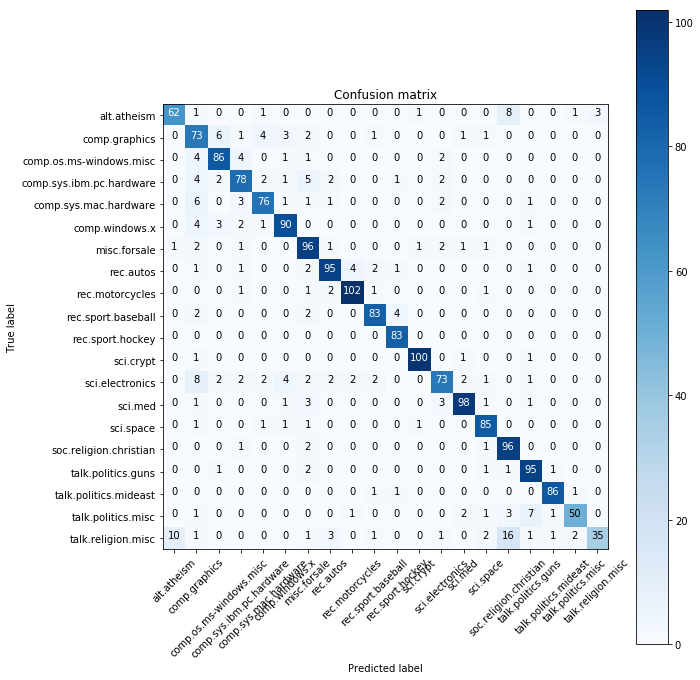

In [161]:
y_pred = clf.predict(X_val)

conf_matrix = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(conf_matrix, newsgroups_all.target_names)

The diagonal represents true positives, the correctly labelled articles, which amount for ~87% of the data points. We can see that our model wrongly assigned some labels to the same erroneous labels many times, and that these labels have categories that are very similar in nature, for example 'soc.religion.christian' and talk.religion.misc', 'talk.religion.misc' and 'alt.atheism', 'sci.electronics' and 'comp.graphics', or other categories that are alike.

These sort of wrongly assigned points are normal, and we can excuse our model for the error, in the sense that, for example, 'soc.religion.christian' can be seen as a category englobed by 'talk.religion.misc', or a refined category. Taking into consideration the fact that the labels were assigned by humans, 
and we could argue that, for _these cases_ of errorenous labels, the model was in fact correct, because more precise that the human labelling.


Let's now have a look at the feature importances.

Because we have vectorized the initial data with tf-idf vectorization, the features we have in X_test represent words, and not the original newspaper categories, as the small exceprt below shows.

In [163]:
names = vectorizer.get_feature_names()
names[60000:60010]

['cumorah_',
 'cumpter',
 'cumshots',
 'cumulative',
 'cuneiform',
 'cunews',
 'cunixa',
 'cunixb',
 'cunixc',
 'cunixf']

Here we plot a semilog histogram of the feature importances of the vectorized features:

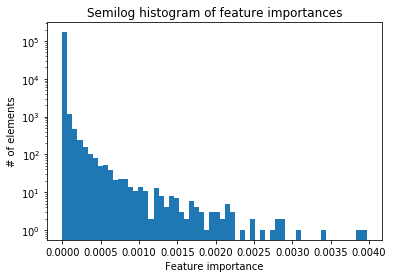

In [164]:
importances = clf.feature_importances_
plt.hist(importances,bins=60)
plt.gca().set_yscale('log')
plt.title('Semilog histogram of feature importances')
plt.xlabel('Feature importance')
plt.ylabel('# of elements')
plt.show()

As the histogram above shows, the feature importance distribution follows a power law distribution. Most of the features have a very small weight, and they are dominated by a minority of features which account of most of the variance in the model. This means that the model selected a few words that were important in the distinction between categories, and that most of them were useless in the classification. This makes sens as the classifier, which is a random forest with high complexity from our parameters, will try and find the best words that can manage to correctly classify a news article.

Finally, let's display some of the words with the biggest feature importance score:

In [165]:
names = vectorizer.get_feature_names()
values = clf.feature_importances_

importance_df = pd.DataFrame(
    {'name': names,
     'importance_value': values
    },index=None)

importance_df.sort_values(by='importance_value', ascending=False, inplace=True)
importance_df.reset_index(drop=True, inplace=True)
importance_df.head(12)

,importance_value,name
0,0.003967,windows
1,0.003852,sale
2,0.003394,dod
3,0.003088,car
4,0.002903,bike
5,0.002874,of
6,0.002828,re
7,0.002786,space
8,0.002731,the
9,0.002599,clipper
